In [1025]:
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pickle
from scipy.signal import butter, lfilter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from scipy import stats as st
from sklearn.ensemble import RandomForestClassifier
import random
import os

seed = 57
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

x = pickle.load(open('x.pkl', 'rb'))
y = pickle.load(open('y.pkl', 'rb'))

In [1026]:
x_normal = np.concatenate((x[:300], x[400:]), axis=0)
print(x_normal.shape)
x_seizure = x[300:400]
print(x_seizure.shape)

(400, 4097)
(100, 4097)


In [1027]:
sampling_freq = 173.6 #based on info from website

b, a = butter(3, [0.5,40], btype='bandpass',fs=sampling_freq)

x_normal_filtered = np.array([lfilter(b,a,x_normal[ind,:]) for ind in range(x_normal.shape[0])]);
print(x_normal_filtered.shape)
x_seizure_filtered = np.array([lfilter(b,a,x_seizure[ind,:]) for ind in range(x_seizure.shape[0])]);
print(x_seizure_filtered.shape)


(400, 4097)
(100, 4097)


In [1028]:
x_normal = x_normal_filtered
x_seizure = x_seizure_filtered

x = np.concatenate((x_normal,x_seizure))
y = np.concatenate((np.zeros((400,1)),np.ones((100,1))))

In [1029]:
# Define a function to plot the data
def plot(x, title):
    plt.plot(x)
    plt.title(title)
    plt.show()

# Define a function to evaluate the model
def evaluation(test, pred):
    print('Accuracy: ', accuracy_score(test, pred))
    print('Recall: ', recall_score(test, pred))
    print('Precision: ', precision_score(test, pred))

In [1030]:
####################### Feature Extraction #######################

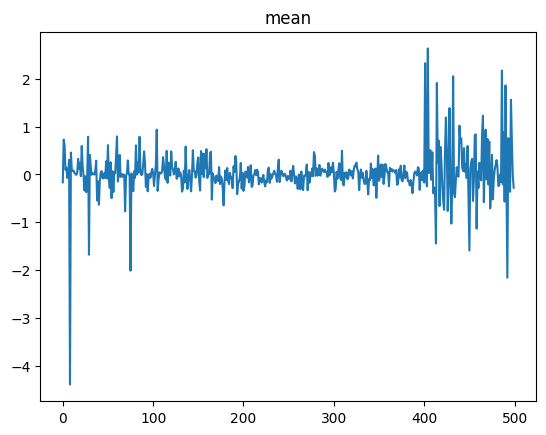

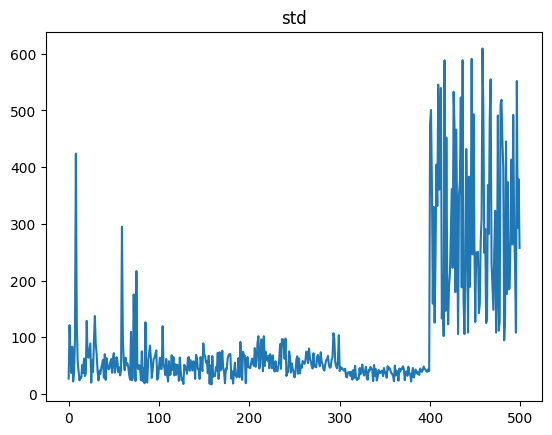

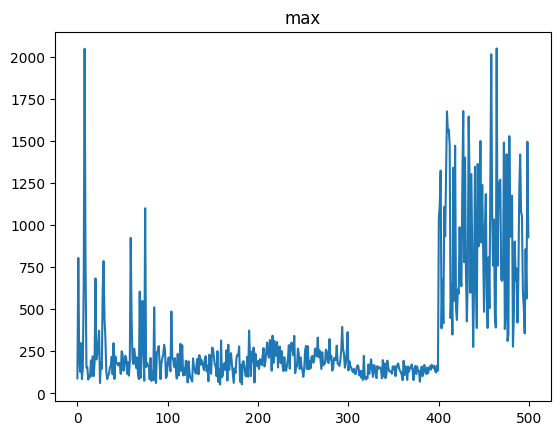

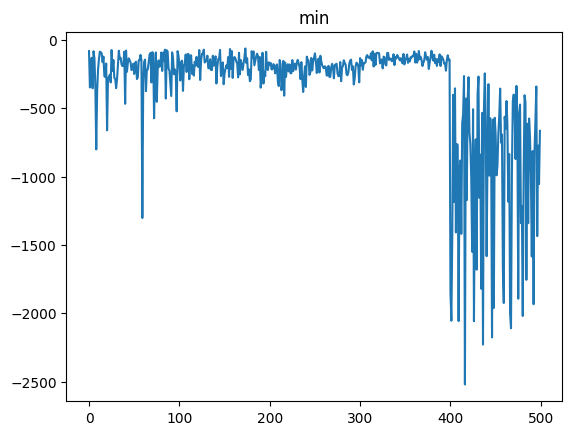

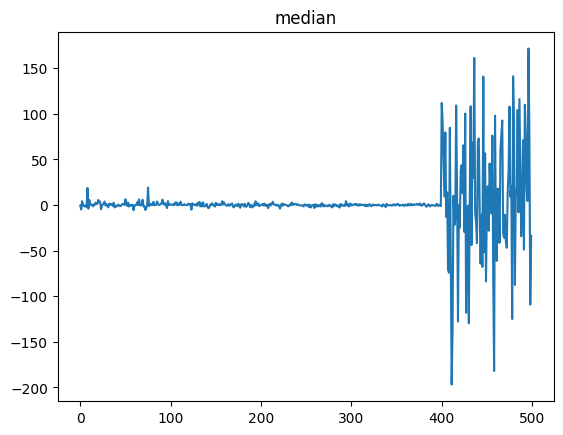

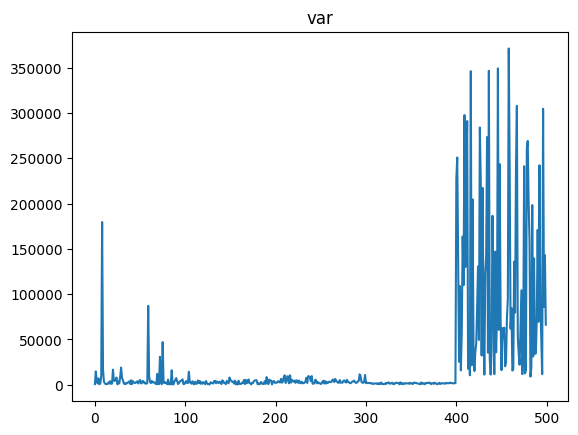

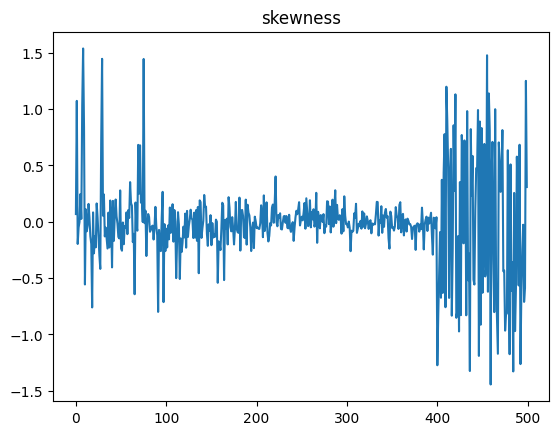

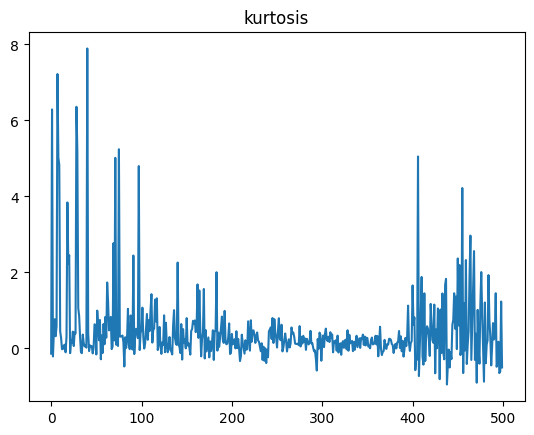

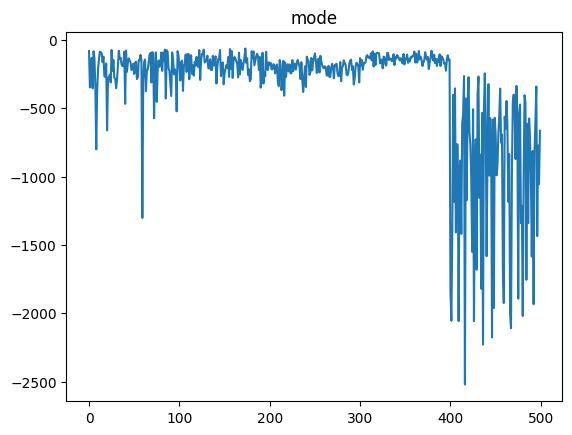

In [1031]:
# Statistical features: mean, std, max, min, median, variance, skewness, kurtosis, mode;
mean = np.mean(x, axis=1)
plot(mean, 'mean')

std = np.std(x, axis=1)
plot(std, 'std')

max = np.max(x, axis=1)
plot(max, 'max')

min = np.min(x, axis=1)
plot(min, 'min')

median = np.median(x, axis=1)
plot(median, 'median')

var = np.var(x, axis=1)
plot(var, 'var')

skewness = st.skew(x, axis=1)
plot(skewness, 'skewness')

kurtosis = st.kurtosis(x, axis=1)
plot(kurtosis, 'kurtosis')

# the output of mode is exactly like the min of our data, so we ignore it.
mode = []
for row in x:
    mode.append(st.mode(row, keepdims=True)[0][0])
mode = np.array(mode)
plot(mode, 'mode')

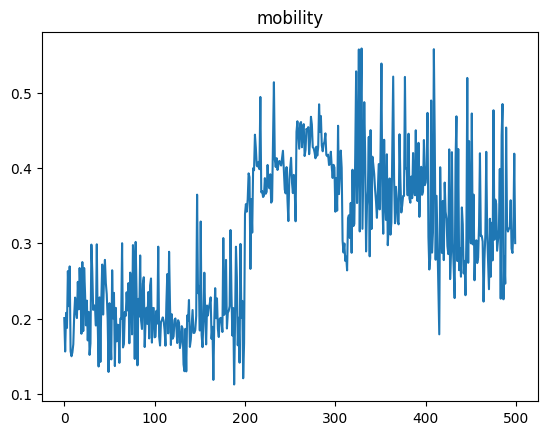

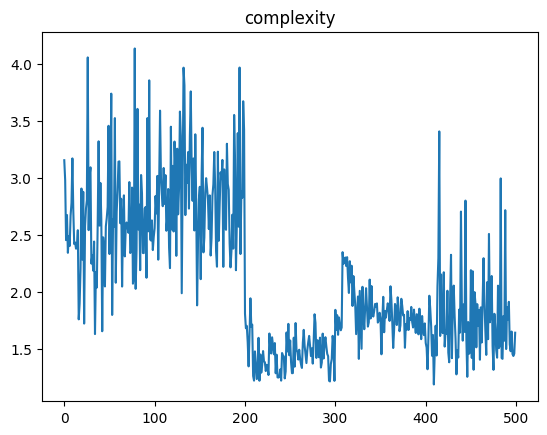

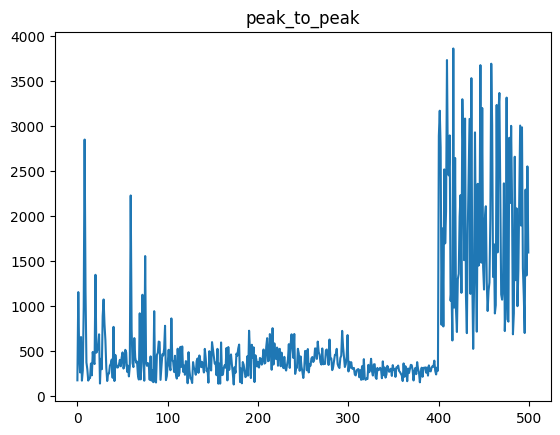

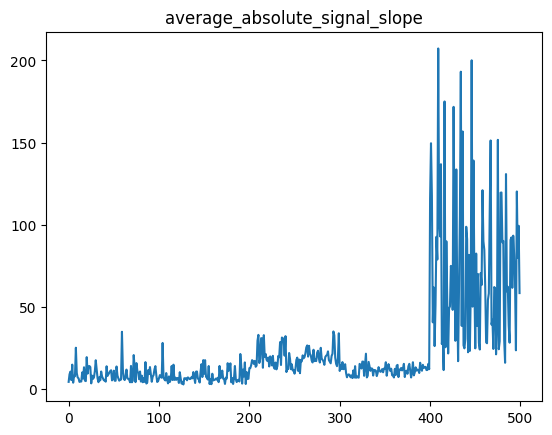

In [1032]:
# Time domain features: mobility, complexity, average absolute signal slope, peak-to-peak
def hjorth_params(x, axis=-1):
    x = np.asarray(x)
    # Calculate derivatives
    dx = np.diff(x, axis=axis)
    ddx = np.diff(dx, axis=axis)
    # Calculate variance
    x_var = np.var(x, axis=axis)  # = activity
    dx_var = np.var(dx, axis=axis)
    ddx_var = np.var(ddx, axis=axis)
    # Mobility and complexity
    mob = np.sqrt(dx_var / x_var)
    com = np.sqrt(ddx_var / dx_var) / mob
    return mob, com

mobility, complexity = hjorth_params(x)
plot(mobility, 'mobility')
plot(complexity, 'complexity')


peak_to_peak = np.ptp(x, axis=1)
plot(peak_to_peak, 'peak_to_peak')

average_absolute_signal_slope = np.mean(np.abs(np.diff(x, axis=1)), axis=1)
plot(average_absolute_signal_slope, 'average_absolute_signal_slope')


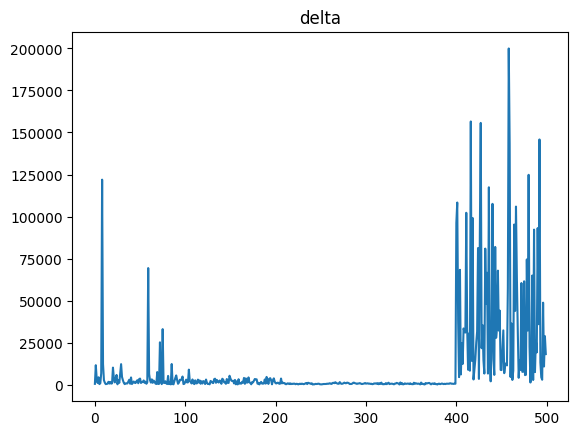

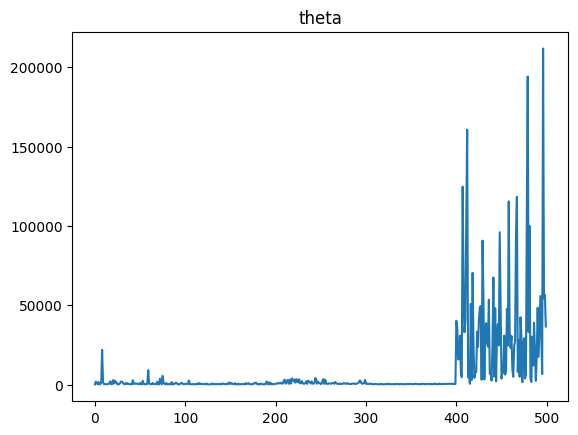

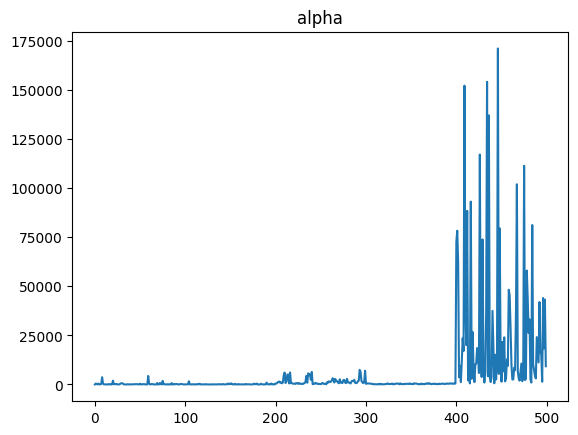

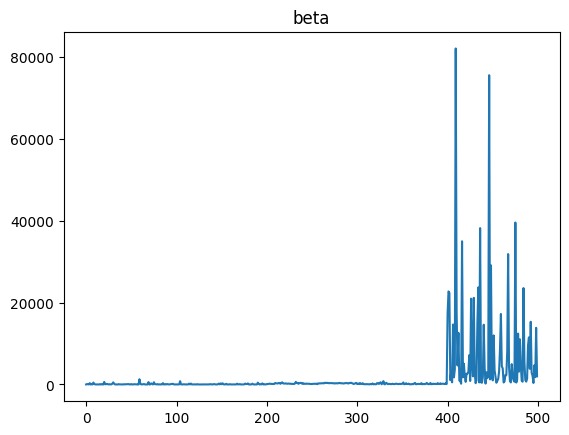

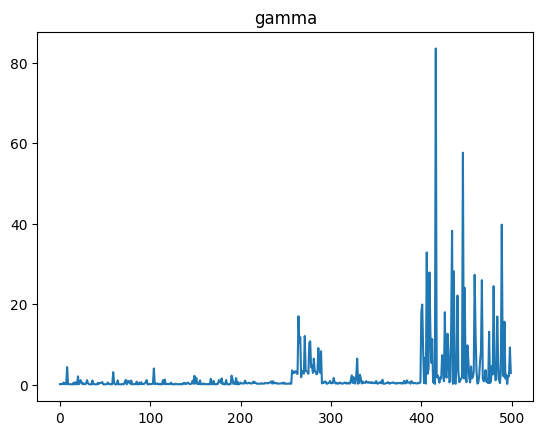

In [1033]:
# Frequency domain features: Delta, Theta, Alpha, Beta, Gamma
def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.
    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If window_sec=None, window_sec = (1 / min(band)) * 2
    relative : bool
        If relative is True, return the relative power (= divided by the total power of the signal).
    Returns
    -------
    bp : float
        Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps

    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

delta = []
theta = []
alpha = []
beta = []
gamma = []

for row in x:
    delta.append(bandpower(row, 128, [0.5, 4], 4))
    theta.append(bandpower(row, 128, [4, 8], 4))
    alpha.append(bandpower(row, 128, [8, 13], 4))
    beta.append(bandpower(row, 128, [13, 30], 4))
    gamma.append(bandpower(row, 128, [30, 50], 4))
delta = np.array(delta)
theta = np.array(theta)
alpha = np.array(alpha)
beta = np.array(beta)
gamma = np.array(gamma)
plot(delta, 'delta')
plot(theta, 'theta')
plot(alpha, 'alpha')
plot(beta, 'beta')
plot(gamma, 'gamma')

(500, 15)


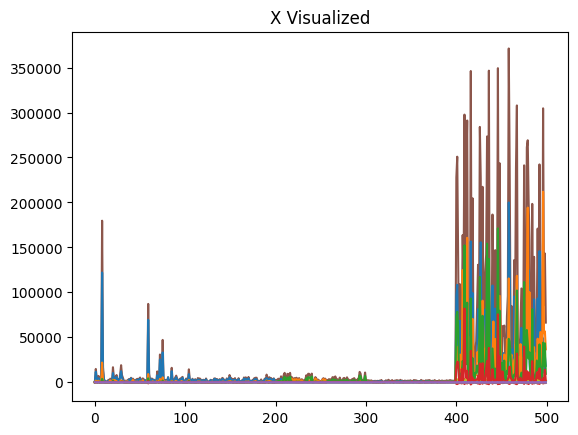

In [1034]:
# Reducing data dimensions using extracted features
x_visualized = np.array([mean, std, max, min, median, var, skewness, kurtosis, peak_to_peak, average_absolute_signal_slope, delta, theta, alpha, beta, gamma])
x_visualized_labels = ['mean', 'std', 'max', 'min', 'median', 'var', 'skewness', 'kurtosis', 'peak_to_peak', 'average_absolute_signal_slope', 'delta', 'theta', 'alpha', 'beta', 'gamma']
x_visualized = x_visualized.T
print(x_visualized.shape)
plot(x_visualized, 'X Visualized')

In [1035]:
####################### Normalization ########################

In [1036]:
from sklearn import preprocessing

# x_normalized = preprocessing.normalize(x_visualized)
# plot(x_normalized, 'X Normalized')

scaler = preprocessing.StandardScaler()
x_normalized = scaler.fit_transform(x_visualized)

In [1037]:
####################### Classification #######################

In [1038]:
# using train_test_split to split data into train and test;
xx_train, xx_test, yy_train, yy_test = train_test_split(x,y,random_state=seed,test_size=0.2)
print(xx_train.shape)
print(xx_test.shape)

(400, 4097)
(100, 4097)


In [1039]:
# using train_test_split to split visualized data into train and test
x_train, x_test, y_train, y_test = train_test_split(x_visualized,y,random_state=seed,test_size=0.2)
print(x_train.shape)
print(x_test.shape)

(400, 15)
(100, 15)


In [1040]:
# using train_test_split to split normalized data into train and test
x_normalized_train, x_normalized_test, y_normalized_train, y_normalized_test = train_test_split(x_normalized,y,random_state=seed,test_size=0.2)

In [1041]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate

def K_fold(x, split):
    train_index=[]
    test_index=[]
    kf = KFold(n_splits = split, shuffle=True)
    kf.split(x)
    for train_i, test_i in kf.split(x):
        train_index.append(train_i)
        test_index.append(test_i)
    return train_index, test_index

kf = KFold(n_splits=5, random_state=seed, shuffle=True)

def cross_validation(clf, x, y):
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'recall': make_scorer(recall_score),
        'precision': make_scorer(precision_score),
    }
    scores = cross_validate(clf, x, y, cv=kf, scoring=scoring)
    print(scores)
    print('Accuracy: ', np.mean(scores['test_accuracy']))
    print('Recall: ', np.mean(scores['test_recall']))
    print('Precision: ', np.mean(scores['test_precision']))

In [1042]:
# using SVM

In [1043]:
# svm with linear kernel that used of train_test_split for splitting data
linear_svm_clf = SVC(kernel='linear')
linear_svm_clf.fit(xx_train, yy_train)
svm_y_pred = linear_svm_clf.predict(xx_test)
evaluation(yy_test,svm_y_pred)

c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:  0.87
Recall:  0.5
Precision:  1.0


In [1044]:
# svm with linear kernel that used of train_test_split for splitting visualized data
linear_svm_clf.fit(x_train, y_train)
svm_y_pred = linear_svm_clf.predict(x_test)
evaluation(y_test,svm_y_pred)

c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:  0.96
Recall:  0.8461538461538461
Precision:  1.0


In [1045]:
# svm with linear kernel that used of train_test_split for splitting normalized data
linear_svm_clf.fit(x_normalized_train, y_normalized_train)
svm_y_pred = linear_svm_clf.predict(x_normalized_test)
evaluation(y_normalized_test,svm_y_pred)

Accuracy:  0.92
Recall:  0.7307692307692307
Precision:  0.95


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [1046]:
# svm with linear kernel that used of cross validation(k_fold) for splitting data
cross_validation(linear_svm_clf, x, y)

c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataC

{'fit_time': array([0.19808888, 0.20150137, 0.17303944, 0.1779604 , 0.16456032]), 'score_time': array([0.03985476, 0.02992249, 0.02796316, 0.0258925 , 0.02497768]), 'test_accuracy': array([0.87, 0.89, 0.86, 0.93, 0.88]), 'test_recall': array([0.5       , 0.38888889, 0.39130435, 0.5       , 0.36842105]), 'test_precision': array([1., 1., 1., 1., 1.])}
Accuracy:  0.8860000000000001
Recall:  0.4297228578693109
Precision:  1.0


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [1047]:
# svm with linear kernel that used of cross validation(k_fold) for splitting visualized data
cross_validation(linear_svm_clf, x_visualized, y)

c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataC

{'fit_time': array([23.29076147, 10.35653925, 18.16047525, 10.96690106, 67.77810574]), 'score_time': array([0.00319433, 0.00299239, 0.00298762, 0.00299668, 0.00199533]), 'test_accuracy': array([0.96, 0.96, 1.  , 0.99, 0.99]), 'test_recall': array([0.84615385, 0.83333333, 1.        , 1.        , 1.        ]), 'test_precision': array([1.        , 0.9375    , 1.        , 0.93333333, 0.95      ])}
Accuracy:  0.9800000000000001
Recall:  0.9358974358974359
Precision:  0.9641666666666667


In [1048]:
# svm with linear kernel that used of cross validation(k_fold) for splitting normalized data
cross_validation(linear_svm_clf, x_normalized, y)

{'fit_time': array([0.00199604, 0.00199556, 0.00303674, 0.00199366, 0.00295258]), 'score_time': array([0.00299215, 0.00398779, 0.00294733, 0.00299168, 0.00203347]), 'test_accuracy': array([0.92, 0.93, 0.99, 0.97, 0.99]), 'test_recall': array([0.73076923, 0.72222222, 0.95652174, 0.85714286, 0.94736842]), 'test_precision': array([0.95      , 0.86666667, 1.        , 0.92307692, 1.        ])}
Accuracy:  0.96
Recall:  0.8428048940634753
Precision:  0.9479487179487179


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataC

In [1049]:
# svm with rbf kernel that used of train_test_split for splitting data
rbf_svm_clf = SVC(kernel='rbf')
rbf_svm_clf.fit(xx_train, yy_train)
svm_y_pred = rbf_svm_clf.predict(xx_test)
evaluation(yy_test,svm_y_pred)

Accuracy:  0.96
Recall:  0.8846153846153846
Precision:  0.9583333333333334


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [1050]:
# svm with rbf kernel that used of train_test_split for splitting visualized data
rbf_svm_clf.fit(x_train, y_train)
svm_y_pred = rbf_svm_clf.predict(x_test)
evaluation(y_test,svm_y_pred)

Accuracy:  0.95
Recall:  0.8461538461538461
Precision:  0.9565217391304348


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [1051]:
# svm with rbf kernel that used of train_test_split for splitting normalized data
rbf_svm_clf.fit(x_normalized_train, y_normalized_train)
svm_y_pred = rbf_svm_clf.predict(x_normalized_test)
evaluation(y_normalized_test,svm_y_pred)

Accuracy:  0.96
Recall:  0.8846153846153846
Precision:  0.9583333333333334


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [1052]:
# svm with rbf kernel that used of cross validation(k_fold) for splitting data
cross_validation(rbf_svm_clf, x, y)

c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataC

{'fit_time': array([0.09475136, 0.09135818, 0.10107112, 0.07730007, 0.08776569]), 'score_time': array([0.02593255, 0.03489876, 0.03287435, 0.02393627, 0.02792454]), 'test_accuracy': array([0.96, 0.96, 0.98, 0.95, 0.96]), 'test_recall': array([0.88461538, 0.77777778, 0.91304348, 0.78571429, 0.78947368]), 'test_precision': array([0.95833333, 1.        , 1.        , 0.84615385, 1.        ])}
Accuracy:  0.962
Recall:  0.8301249221157688
Precision:  0.9608974358974359


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [1053]:
# svm with rbf kernel that used of cross validation(k_fold) for splitting visualized data
cross_validation(rbf_svm_clf, x_visualized, y)

{'fit_time': array([0.00299311, 0.00203228, 0.00300717, 0.00199509, 0.00203681]), 'score_time': array([0.00299168, 0.00295782, 0.00293398, 0.0029912 , 0.00299144]), 'test_accuracy': array([0.95, 0.95, 0.99, 0.95, 0.95]), 'test_recall': array([0.84615385, 0.77777778, 0.95652174, 0.78571429, 0.73684211]), 'test_precision': array([0.95652174, 0.93333333, 1.        , 0.84615385, 1.        ])}
Accuracy:  0.958
Recall:  0.8206019508079004
Precision:  0.9472017837235228


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataC

In [1054]:
# svm with rbf kernel that used of cross validation(k_fold) for splitting normalized data
cross_validation(rbf_svm_clf, x_normalized, y)

c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'fit_time': array([0.00299072, 0.00299096, 0.00299263, 0.00199461, 0.00199342]), 'score_time': array([0.00299287, 0.0029912 , 0.00299168, 0.00299191, 0.00299096]), 'test_accuracy': array([0.96, 0.96, 1.  , 0.97, 0.97]), 'test_recall': array([0.88461538, 0.88888889, 1.        , 0.85714286, 0.84210526]), 'test_precision': array([0.95833333, 0.88888889, 1.        , 0.92307692, 1.        ])}
Accuracy:  0.9719999999999999
Recall:  0.8945504787610051
Precision:  0.9540598290598291


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataC

In [1055]:
# svm with poly kernel that used of train_test_split for splitting data
poly_svm_clf = SVC(kernel='poly')
poly_svm_clf.fit(xx_train, yy_train)
svm_y_pred = poly_svm_clf.predict(xx_test)
evaluation(yy_test,svm_y_pred)

c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:  0.8
Recall:  0.23076923076923078
Precision:  1.0


In [1056]:
# svm with poly kernel that used of train_test_split for splitting visualized data
poly_svm_clf.fit(x_train, y_train)
svm_y_pred = poly_svm_clf.predict(x_test)
evaluation(y_test,svm_y_pred)

Accuracy:  0.88
Recall:  0.5769230769230769
Precision:  0.9375


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [1057]:
# svm with poly kernel that used of train_test_split for splitting normalized data
poly_svm_clf.fit(x_normalized_train, y_normalized_train)
svm_y_pred = poly_svm_clf.predict(x_normalized_test)
evaluation(y_normalized_test,svm_y_pred)

Accuracy:  0.9
Recall:  0.6538461538461539
Precision:  0.9444444444444444


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [1058]:
# svm with poly kernel that used of cross validation(k_fold) for splitting data
cross_validation(poly_svm_clf, x, y)

c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataC

{'fit_time': array([0.3134656 , 0.27853155, 0.28593874, 0.2742269 , 0.26126051]), 'score_time': array([0.06982517, 0.0508635 , 0.05389333, 0.05787182, 0.05489373]), 'test_accuracy': array([0.8 , 0.84, 0.79, 0.9 , 0.85]), 'test_recall': array([0.23076923, 0.11111111, 0.08695652, 0.28571429, 0.21052632]), 'test_precision': array([1., 1., 1., 1., 1.])}
Accuracy:  0.836
Recall:  0.18501549302464632
Precision:  1.0


In [1059]:
# svm with poly kernel that used of cross validation(k_fold) for splitting visualized data
cross_validation(poly_svm_clf, x_visualized, y)

{'fit_time': array([0.00299311, 0.00199485, 0.00299072, 0.00299001, 0.00199413]), 'score_time': array([0.00199509, 0.00299072, 0.00299382, 0.00299263, 0.00399041]), 'test_accuracy': array([0.88, 0.91, 0.94, 0.94, 0.93]), 'test_recall': array([0.57692308, 0.5       , 0.73913043, 0.57142857, 0.63157895]), 'test_precision': array([0.9375, 1.    , 1.    , 1.    , 1.    ])}
Accuracy:  0.9199999999999999
Recall:  0.6038122061005357
Precision:  0.9875


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataC

In [1060]:
# svm with poly kernel that used of cross validation(k_fold) for splitting normalized data
cross_validation(poly_svm_clf, x_normalized, y)

{'fit_time': array([0.00199509, 0.00299239, 0.00299239, 0.00299191, 0.0029912 ]), 'score_time': array([0.00299168, 0.00299072, 0.00299168, 0.00199461, 0.00199533]), 'test_accuracy': array([0.9 , 0.93, 0.94, 0.95, 0.93]), 'test_recall': array([0.65384615, 0.61111111, 0.73913043, 0.71428571, 0.63157895]), 'test_precision': array([0.94444444, 1.        , 1.        , 0.90909091, 1.        ])}
Accuracy:  0.9299999999999999
Recall:  0.6699904722788018
Precision:  0.9707070707070707


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataC

In [1061]:
# svm with sigmoid kernel that used of train_test_split for splitting data
sigmoid_svm_clf = SVC(kernel='sigmoid')
sigmoid_svm_clf.fit(xx_train, yy_train)
svm_y_pred = sigmoid_svm_clf.predict(xx_test)
evaluation(yy_test,svm_y_pred)

c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:  0.8
Recall:  0.23076923076923078
Precision:  1.0


In [1062]:
# svm with sigmoid kernel that used of train_test_split for splitting visualized data
sigmoid_svm_clf.fit(x_train, y_train)
svm_y_pred = sigmoid_svm_clf.predict(x_test)
evaluation(y_test,svm_y_pred)

Accuracy:  0.9
Recall:  0.8076923076923077
Precision:  0.8076923076923077


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [1063]:
# svm with sigmoid kernel that used of train_test_split for splitting normalized data
sigmoid_svm_clf.fit(x_normalized_train, y_normalized_train)
svm_y_pred = sigmoid_svm_clf.predict(x_normalized_test)
evaluation(y_normalized_test,svm_y_pred)

Accuracy:  0.91
Recall:  0.7307692307692307
Precision:  0.9047619047619048


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [1064]:
# svm with sigmoid kernel that used of cross validation(k_fold) for splitting data;
cross_validation(sigmoid_svm_clf, x, y)

c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataC

{'fit_time': array([0.18299031, 0.19733763, 0.17711473, 0.19547796, 0.21841526]), 'score_time': array([0.03494573, 0.03091717, 0.03287005, 0.04088902, 0.0458777 ]), 'test_accuracy': array([0.8 , 0.84, 0.82, 0.87, 0.86]), 'test_recall': array([0.23076923, 0.11111111, 0.2173913 , 0.14285714, 0.26315789]), 'test_precision': array([1.        , 1.        , 1.        , 0.66666667, 1.        ])}
Accuracy:  0.8380000000000001
Recall:  0.19305733676443054
Precision:  0.9333333333333332


In [1065]:
# svm with sigmoid kernel that used of cross validation(k_fold) for splitting visualized data;
cross_validation(sigmoid_svm_clf, x_visualized, y)

{'fit_time': array([0.00398993, 0.00199485, 0.00404835, 0.0039897 , 0.00398898]), 'score_time': array([0.0029912 , 0.00299239, 0.00392914, 0.00398874, 0.00398874]), 'test_accuracy': array([0.9 , 0.95, 0.98, 0.94, 0.95]), 'test_recall': array([0.80769231, 0.72222222, 0.91304348, 0.71428571, 0.73684211]), 'test_precision': array([0.80769231, 1.        , 1.        , 0.83333333, 1.        ])}
Accuracy:  0.944
Recall:  0.7788171655448544
Precision:  0.9282051282051281


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataC

In [1066]:
# svm with sigmoid kernel that used of cross validation(k_fold) for splitting normalized data;
cross_validation(sigmoid_svm_clf, x_normalized, y)

{'fit_time': array([0.00398803, 0.00299191, 0.00299072, 0.00299144, 0.0029912 ]), 'score_time': array([0.0049963 , 0.00498581, 0.00299215, 0.00399017, 0.00299239]), 'test_accuracy': array([0.92, 0.93, 1.  , 0.95, 0.96]), 'test_recall': array([0.73076923, 0.66666667, 1.        , 0.78571429, 0.84210526]), 'test_precision': array([0.95      , 0.92307692, 1.        , 0.84615385, 0.94117647])}
Accuracy:  0.952
Recall:  0.8050510892616156
Precision:  0.932081447963801


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataC

In [1067]:
# using Random Forest

In [1068]:
# random forest that used of train_test_split for splitting data
random_forest_clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=seed)
random_forest_clf.fit(xx_train, yy_train)
random_forest_y_pred = random_forest_clf.predict(xx_test)
evaluation(yy_test,random_forest_y_pred)

C:\Users\KASRA\AppData\Local\Temp\ipykernel_16864\3153351049.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_clf.fit(xx_train, yy_train)


Accuracy:  0.92
Recall:  0.6923076923076923
Precision:  1.0


In [1069]:
# random forest that used of train_test_split for splitting normalized data
random_forest_clf.fit(x_normalized_train, y_normalized_train)
random_forest_y_pred = random_forest_clf.predict(x_normalized_test)
evaluation(y_normalized_test,random_forest_y_pred)

Accuracy:  0.98
Recall:  0.9615384615384616
Precision:  0.9615384615384616


C:\Users\KASRA\AppData\Local\Temp\ipykernel_16864\660652933.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_clf.fit(x_normalized_train, y_normalized_train)


In [1070]:
# random forest that used of train_test_split for splitting visualized data
random_forest_clf.fit(x_train, y_train)
random_forest_y_pred = random_forest_clf.predict(x_test)
evaluation(y_test,random_forest_y_pred)

Accuracy:  0.98
Recall:  0.9615384615384616
Precision:  0.9615384615384616


C:\Users\KASRA\AppData\Local\Temp\ipykernel_16864\2061175495.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_clf.fit(x_train, y_train)


In [1071]:
# random forest that used of cross validation(k_fold) for splitting data;
cross_validation(random_forest_clf, x, y)

c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\KASRA\AppData\Local\Programs\Py

{'fit_time': array([0.74899602, 0.70338321, 0.712605  , 0.70965981, 0.70107889]), 'score_time': array([0.01198149, 0.01097083, 0.01196647, 0.01097059, 0.01097035]), 'test_accuracy': array([0.91, 0.93, 0.95, 0.95, 0.92]), 'test_recall': array([0.65384615, 0.61111111, 0.7826087 , 0.64285714, 0.57894737]), 'test_precision': array([1., 1., 1., 1., 1.])}
Accuracy:  0.932
Recall:  0.6538740943775269
Precision:  1.0


In [1072]:
# random forest that used of cross validation(k_fold) for splitting visualized data;
cross_validation(random_forest_clf, x_visualized, y)

c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\KASRA\AppData\Local\Programs\Py

{'fit_time': array([0.15159249, 0.16056967, 0.14959979, 0.15259242, 0.14959931]), 'score_time': array([0.00997329, 0.00997329, 0.00997353, 0.0099721 , 0.01197243]), 'test_accuracy': array([0.98, 0.95, 1.  , 0.98, 0.97]), 'test_recall': array([0.96153846, 0.83333333, 1.        , 1.        , 0.94736842]), 'test_precision': array([0.96153846, 0.88235294, 1.        , 0.875     , 0.9       ])}
Accuracy:  0.976
Recall:  0.9484480431848853
Precision:  0.9237782805429864


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


In [1073]:
# random forest that used of cross validation(k_fold) for splitting normalized data;
cross_validation(random_forest_clf, x_normalized, y)

c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\KASRA\AppData\Local\Programs\Py

{'fit_time': array([0.17154121, 0.16979647, 0.14860439, 0.20441294, 0.16456032]), 'score_time': array([0.00897551, 0.00997257, 0.01300311, 0.01296568, 0.01096964]), 'test_accuracy': array([0.98, 0.95, 1.  , 0.98, 0.97]), 'test_recall': array([0.96153846, 0.83333333, 1.        , 1.        , 0.94736842]), 'test_precision': array([0.96153846, 0.88235294, 1.        , 0.875     , 0.9       ])}
Accuracy:  0.976
Recall:  0.9484480431848853
Precision:  0.9237782805429864


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


In [1074]:
# using KNN

In [1075]:
# knn that used of train_test_split for splitting data
knn_clf = KNeighborsClassifier(n_neighbors=2)
knn_clf.fit(xx_train, yy_train)
knn_y_pred = knn_clf.predict(xx_test)
evaluation(yy_test,knn_y_pred)

Accuracy:  0.78
Recall:  0.15384615384615385
Precision:  1.0


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [1076]:
# knn that used of train_test_split for splitting visualized data
knn_clf.fit(x_train, y_train)
knn_y_pred = knn_clf.predict(x_test)
evaluation(y_test,knn_y_pred)

Accuracy:  0.95
Recall:  0.8461538461538461
Precision:  0.9565217391304348


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [1077]:
# knn that used of train_test_split for splitting normalized data
knn_clf.fit(x_normalized_train, y_normalized_train)
knn_y_pred = knn_clf.predict(x_normalized_test)
evaluation(y_normalized_test,knn_y_pred)

Accuracy:  0.97
Recall:  0.8846153846153846
Precision:  1.0


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [1078]:
# knn that used of cross validation(k_fold) for splitting data;
cross_validation(knn_clf, x, y)

c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:215: 

{'fit_time': array([0.02892137, 0.0109725 , 0.01097059, 0.0069809 , 0.0089767 ]), 'score_time': array([0.02792549, 0.02592778, 0.02393627, 0.01795197, 0.02094483]), 'test_accuracy': array([0.78, 0.85, 0.8 , 0.89, 0.86]), 'test_recall': array([0.15384615, 0.16666667, 0.13043478, 0.21428571, 0.26315789]), 'test_precision': array([1., 1., 1., 1., 1.])}
Accuracy:  0.836
Recall:  0.1856782424288145
Precision:  1.0


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [1079]:
# knn that used of cross validation(k_fold) for splitting visualized data;
cross_validation(knn_clf, x_visualized, y)

{'fit_time': array([0.00199342, 0.00199294, 0.00199437, 0.00099754, 0.00199413]), 'score_time': array([0.00698233, 0.01296496, 0.00498605, 0.00698352, 0.01296544]), 'test_accuracy': array([0.95, 0.92, 1.  , 0.97, 0.98]), 'test_recall': array([0.84615385, 0.66666667, 1.        , 0.92857143, 0.94736842]), 'test_precision': array([0.95652174, 0.85714286, 1.        , 0.86666667, 0.94736842])}
Accuracy:  0.9640000000000001
Recall:  0.8777520724889147
Precision:  0.9255399367985181


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:215: 

In [1080]:
# knn that used of cross validation(k_fold) for splitting normalized data;
cross_validation(knn_clf, x_normalized, y)

{'fit_time': array([0.00199461, 0.00099707, 0.00099778, 0.0009973 , 0.00099659]), 'score_time': array([0.00798249, 0.00598502, 0.0079782 , 0.00598431, 0.00598454]), 'test_accuracy': array([0.97, 0.95, 1.  , 0.96, 0.98]), 'test_recall': array([0.88461538, 0.83333333, 1.        , 0.78571429, 0.89473684]), 'test_precision': array([1.        , 0.88235294, 1.        , 0.91666667, 1.        ])}
Accuracy:  0.9719999999999999
Recall:  0.8796799691536533
Precision:  0.9598039215686274


c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\KASRA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:215: 

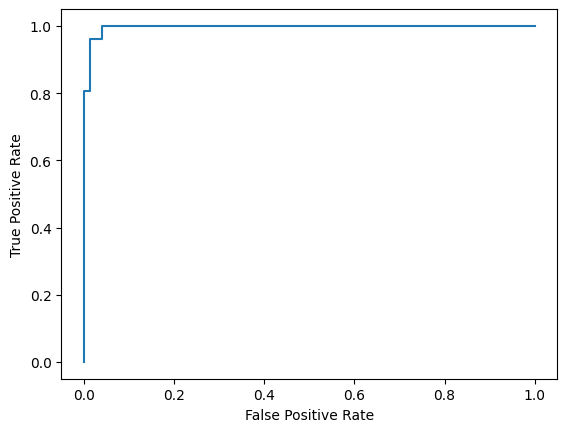

In [1081]:
# Drawing ROC curve
y_score = random_forest_clf.predict_proba(x_test)[::,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test,  y_score);
auc = roc_auc_score(y_test, y_score)
plt.plot(false_positive_rate,true_positive_rate,label="auc="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

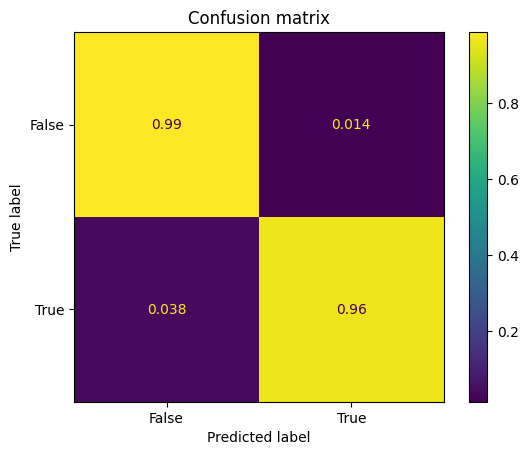

In [1082]:
# Drawing confusion matrix
cm = confusion_matrix(y_test, random_forest_y_pred, normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
cm_display.plot()
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [1083]:
####################################### phase 2 #######################################

In [1084]:
# How well each feature acts on its own

In [1085]:
from sklearn.tree import DecisionTreeClassifier

In [1086]:
# calculate the accuracy of each feature

id3 = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=seed)

feature_scores = []
for i in range(0, x_visualized.shape[1]):
    x_train, x_test, y_train, y_test = train_test_split(x_visualized[:, i].reshape(-1, 1), y, test_size=0.2, random_state=seed)
    id3.fit(x_train, y_train)
    feature_scores.append(id3.score(x_test, y_test))
    print('the accuracy of feature', i,':', x_visualized_labels[i], 'is', feature_scores[i])


the accuracy of feature 0 : mean is 0.79
the accuracy of feature 1 : std is 0.96
the accuracy of feature 2 : max is 0.95
the accuracy of feature 3 : min is 0.95
the accuracy of feature 4 : median is 0.98
the accuracy of feature 5 : var is 0.96
the accuracy of feature 6 : skewness is 0.93
the accuracy of feature 7 : kurtosis is 0.77
the accuracy of feature 8 : peak_to_peak is 0.93
the accuracy of feature 9 : average_absolute_signal_slope is 0.91
the accuracy of feature 10 : delta is 0.93
the accuracy of feature 11 : theta is 0.95
the accuracy of feature 12 : alpha is 0.93
the accuracy of feature 13 : beta is 0.95
the accuracy of feature 14 : gamma is 0.79


In [1087]:
# How different is each feature from the rest of features in general

In [1088]:
# select top 1 feature
index = feature_scores.index(np.max(feature_scores))
selected_features_index = []
selected_features = []
selected_features.append(x_visualized[:, index].reshape(-1, 1).T)
selected_features_index.append(index)
print('the selected feature is', index, ':', x_visualized_labels[index])

the selected feature is 4 : median


In [1089]:
# while the number of selected features be equal to 10
while len(selected_features) < 10:
  corr_reverse = np.zeros(x_visualized.shape[1])
  # loop over all features
  for i in range(0, x_visualized.shape[1]):
    # if the feature is not selected
    if i not in selected_features_index:
      max_corr = 0
      # loop over all selected features
      for j in range(0, len(selected_features)):
        # calculate the abs correlation between the i-th feature and the j-th selected feature
        correlation = abs(np.corrcoef(selected_features[j], x_visualized[:, i].reshape(-1, 1).T)[0, 1])
        if correlation > max_corr:
          max_corr = correlation
      corr_reverse[i] = 1/max_corr
      # corr_reverse[i] = 1 - max_corr
    else:
      corr_reverse[i] = 0
  # normalize corr  between 0 and 1
  corr_reverse = (corr_reverse - np.min(corr_reverse)) / (np.max(corr_reverse) - np.min(corr_reverse))
  f1 = (2 * corr_reverse * feature_scores) / (corr_reverse + feature_scores)
  # select the feature with the maximum f1 if it is not selected before
  index = np.argmax(f1)
  while index in selected_features_index:
    f1[index] = 0
    index = np.argmax(f1)
  selected_features_index.append(index)
  selected_features.append(x_visualized[:, index].reshape(-1, 1).T)
for i in range(0, len(selected_features_index)):
  print('the selected feature', i, 'is', x_visualized_labels[selected_features_index[i]], ' ', selected_features_index[i])

the selected feature 0 is median   4
the selected feature 1 is max   2
the selected feature 2 is mean   0
the selected feature 3 is kurtosis   7
the selected feature 4 is beta   13
the selected feature 5 is theta   11
the selected feature 6 is skewness   6
the selected feature 7 is delta   10
the selected feature 8 is min   3
the selected feature 9 is var   5


In [1090]:
# convert selected features shape from (10, 1, 500) to (500, 10)
selected_features = np.array(selected_features)
selected_features = np.reshape(selected_features, (10, 500)).T
selected_features.shape

(500, 10)

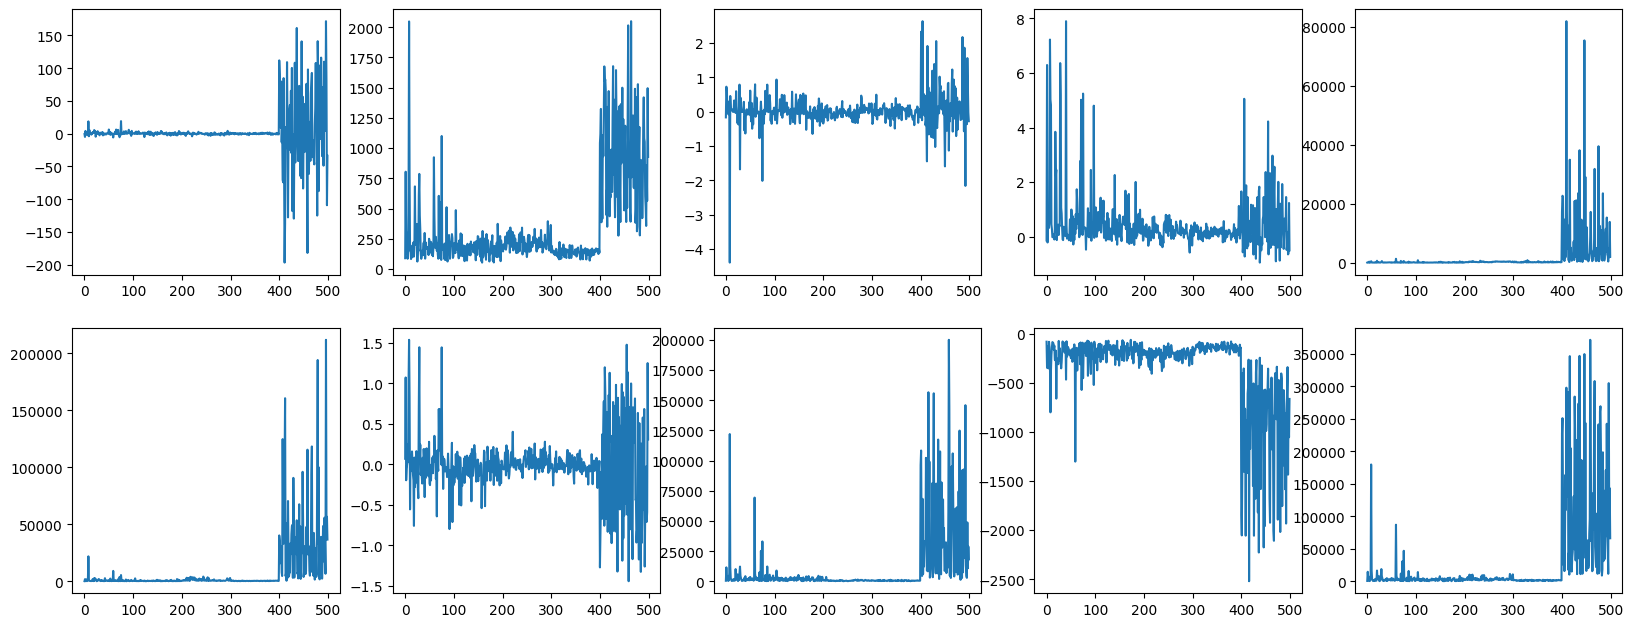

In [1091]:
# plot the primary selected features in one figure
plt.figure(figsize=(20, 20))
for i in range(0, selected_features.shape[1]):
    #normal plot
    plt.subplot(5, 5, i+1)
    plt.plot(selected_features[:, i])
plt.show()

In [1092]:
# Improving accuracy with clustering

In [1093]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def wcss(x_train):
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters = i, n_init=10, random_state = 42)
        kmeans.fit(x_train)
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, 11), wcss)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

def silhouette(x_train):
    scores = []
    for k in range(2,11):
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
        kmeans.fit(x_train)
        score = silhouette_score(x_train, kmeans.labels_)
        scores.append(score)
    plt.plot(range(2,11), scores)
    plt.title('Silhouette Score')
    plt.xlabel('Number of clusters')
    plt.ylabel('Score')
    plt.show()

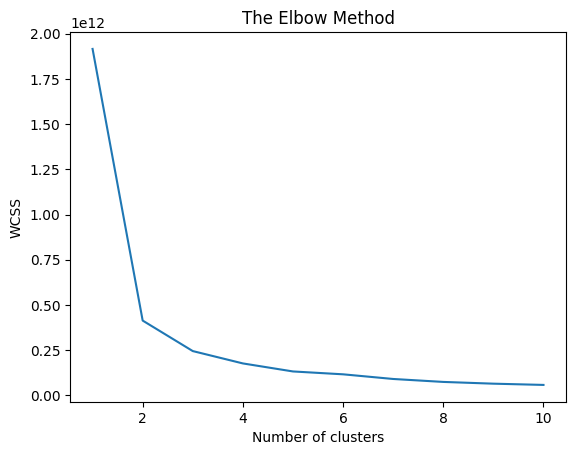

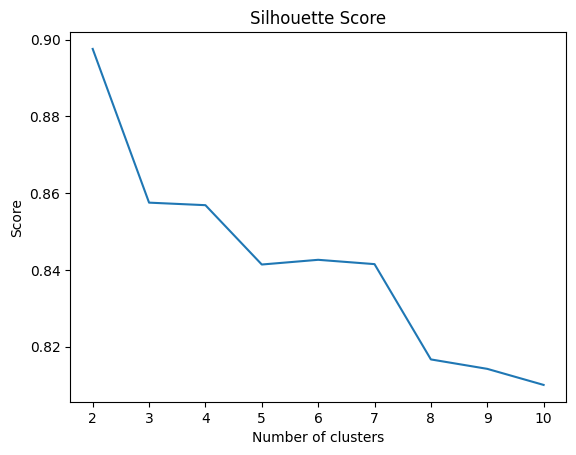

In [1094]:
x_train, x_test, y_train, y_test = train_test_split(selected_features, y, test_size=0.2, random_state=seed)
wcss(x_train)
silhouette(x_train)

In [1095]:
from sklearn.metrics import f1_score
def k_means(x_train, x_test, y_train, y_test, n_clusters):
  kmeans = KMeans(n_clusters, random_state=seed, n_init=10).fit(x_train)
  # plot the clusters
  plt.figure(figsize=(20, 20))
  for i in range(0, kmeans.n_clusters):
      plt.subplot(5, 5, i+1)
      plt.scatter(x_train[kmeans.labels_ == i, 0], x_train[kmeans.labels_ == i, 1])
      print('the number of cluster', i, 'is', len(x_train[kmeans.labels_ == i]))
  plt.show()
  plt.scatter(x_train[:, 0], x_train[:, 1], c=kmeans.labels_, cmap='rainbow')
  # train each cluster with Random Forest classifier
  random_forest_clf_cluster = []
  for i in range(0, kmeans.n_clusters):
      # train the i-th cluster with Random Forest classifier
      random_forest_clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=seed)
      random_forest_clf.fit(x_train[kmeans.labels_ == i], y_train[kmeans.labels_ == i])
      random_forest_clf_cluster.append(random_forest_clf)
  # predict  the test data using the corresponding cluster
  y_pred = []
  for i in range(0, x_test.shape[0]):
      y_pred.append(random_forest_clf_cluster[kmeans.predict(x_test[i].reshape(1, -1))[0]].predict(x_test[i].reshape(1, -1)))
  y_pred = np.array(y_pred).reshape(-1, 1)
  # calculate the accuracy, precision, recall, f1-score
  print('accuracy: ', accuracy_score(y_test, y_pred))
  print('precision: ', precision_score(y_test, y_pred, average='macro'))
  print('recall: ', recall_score(y_test, y_pred, average='macro'))
  print('f1-score: ', f1_score(y_test, y_pred, average='macro'))

the number of cluster 0 is 339
the number of cluster 1 is 10
the number of cluster 2 is 16
the number of cluster 3 is 4
the number of cluster 4 is 30
the number of cluster 5 is 1


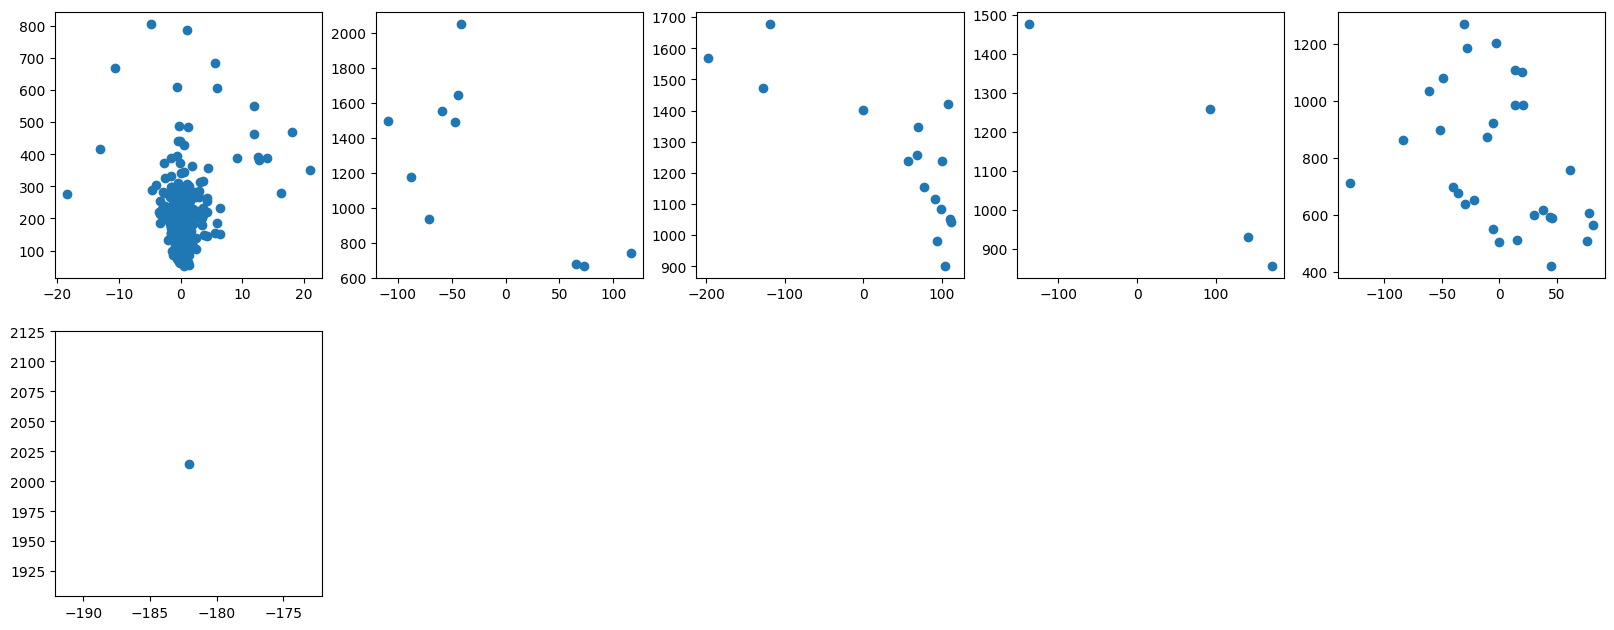

C:\Users\KASRA\AppData\Local\Temp\ipykernel_16864\466768331.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_clf.fit(x_train[kmeans.labels_ == i], y_train[kmeans.labels_ == i])
C:\Users\KASRA\AppData\Local\Temp\ipykernel_16864\466768331.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_clf.fit(x_train[kmeans.labels_ == i], y_train[kmeans.labels_ == i])
C:\Users\KASRA\AppData\Local\Temp\ipykernel_16864\466768331.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_clf.fit(x_train[kmeans.labels_ == i], y_train[kmeans.labels_ == i])
C:\Users\KASRA\AppData\Local\Temp\ipykernel_16864\466768331.py:17: DataConversionW

accuracy:  0.98
precision:  0.974012474012474
recall:  0.974012474012474
f1-score:  0.974012474012474


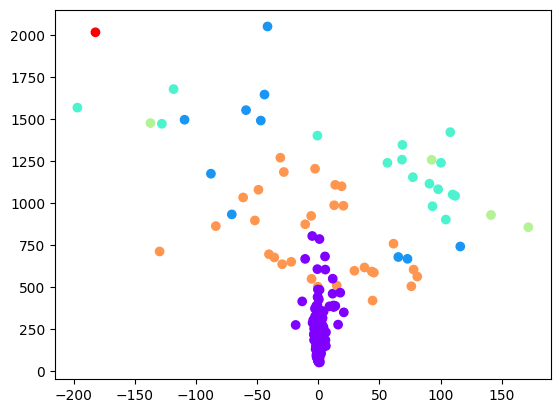

In [1096]:
k_means(x_train, x_test, y_train, y_test, 6)

In [1097]:
# Evaluation with different modes

In [1098]:
# A: Healthy people with open eyes
# B: Healthy people with closed eyes
# C: Sick people with open eyes
# D: Sick people with closed eyes
# E: People with seizures
x_a = selected_features[0:100, :]
x_b = selected_features[100:200, :]
x_c = selected_features[200:300, :]
x_d = selected_features[300:400, :]
x_e = selected_features[400:500, :]

In [1099]:
# 2 classes
# A and E
# B and E
# C and E

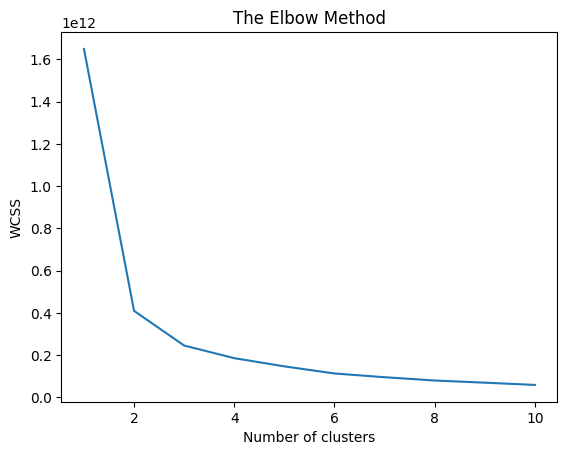

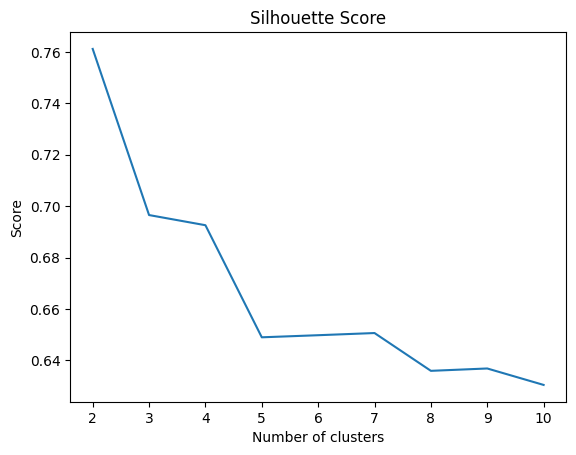

In [1100]:
# A and E
x = np.concatenate((x_a, x_e), axis=0)
y_a = np.zeros((100, 1))
y_e = np.ones((100, 1))
y = np.concatenate((y_a, y_e), axis=0)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)
wcss(x_train)
silhouette(x_train)

the number of cluster 0 is 32
the number of cluster 1 is 128


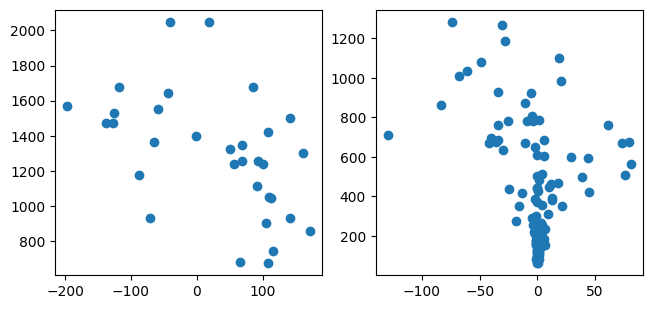

C:\Users\KASRA\AppData\Local\Temp\ipykernel_16864\466768331.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_clf.fit(x_train[kmeans.labels_ == i], y_train[kmeans.labels_ == i])
C:\Users\KASRA\AppData\Local\Temp\ipykernel_16864\466768331.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_clf.fit(x_train[kmeans.labels_ == i], y_train[kmeans.labels_ == i])


accuracy:  0.975
precision:  0.98
recall:  0.96875
f1-score:  0.9736668861092824


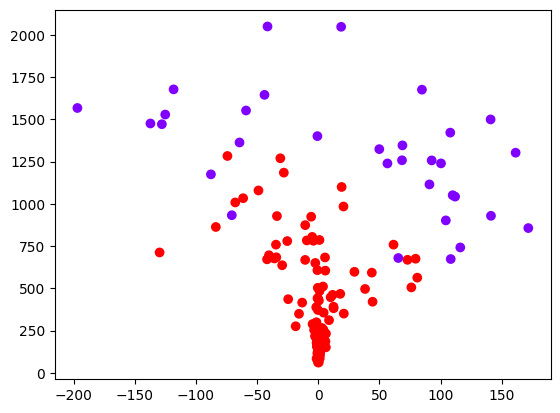

In [1101]:
k_means(x_train, x_test, y_train, y_test, 2)

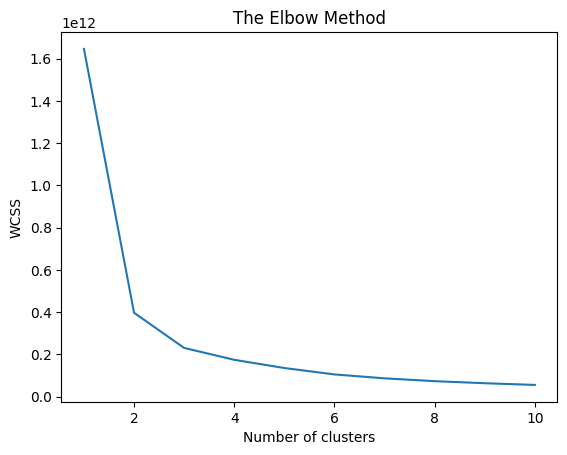

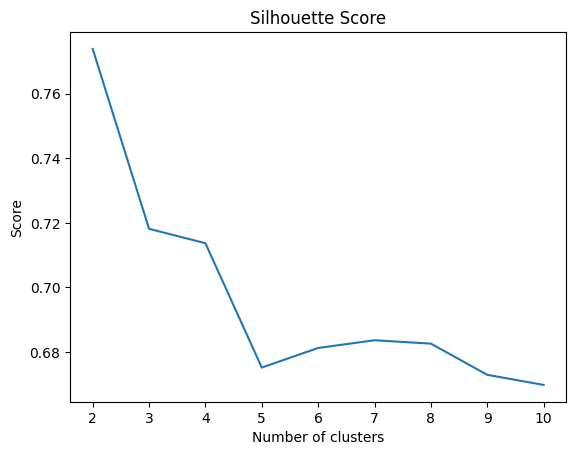

In [1102]:
# B and E
x = np.concatenate((x_b, x_e), axis=0)
y_b = np.zeros((100, 1))
y_e = np.ones((100, 1))
y = np.concatenate((y_b, y_e), axis=0)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)
wcss(x_train)
silhouette(x_train)

the number of cluster 0 is 31
the number of cluster 1 is 129


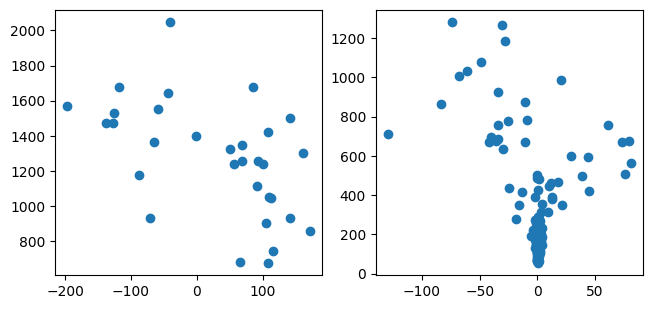

C:\Users\KASRA\AppData\Local\Temp\ipykernel_16864\466768331.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_clf.fit(x_train[kmeans.labels_ == i], y_train[kmeans.labels_ == i])
C:\Users\KASRA\AppData\Local\Temp\ipykernel_16864\466768331.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_clf.fit(x_train[kmeans.labels_ == i], y_train[kmeans.labels_ == i])


accuracy:  0.975
precision:  0.98
recall:  0.96875
f1-score:  0.9736668861092824


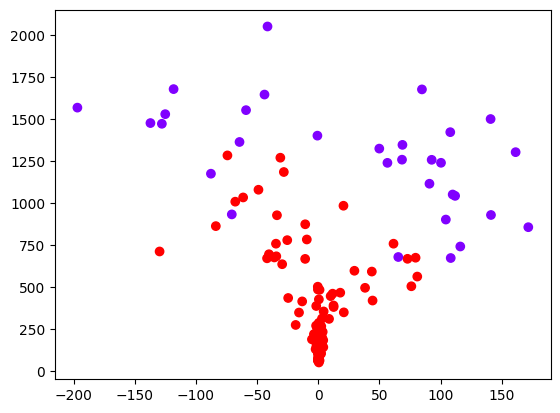

In [1103]:
k_means(x_train, x_test, y_train, y_test, 2)

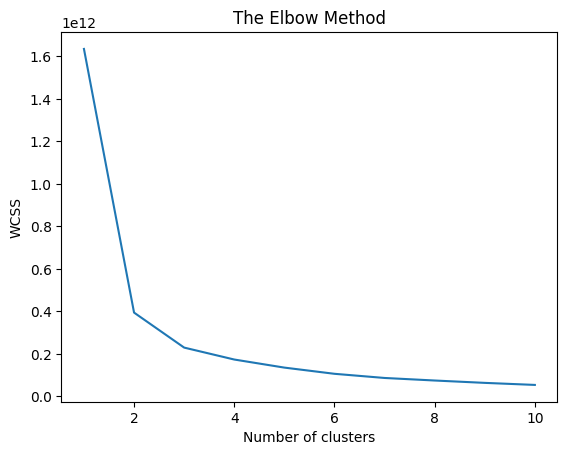

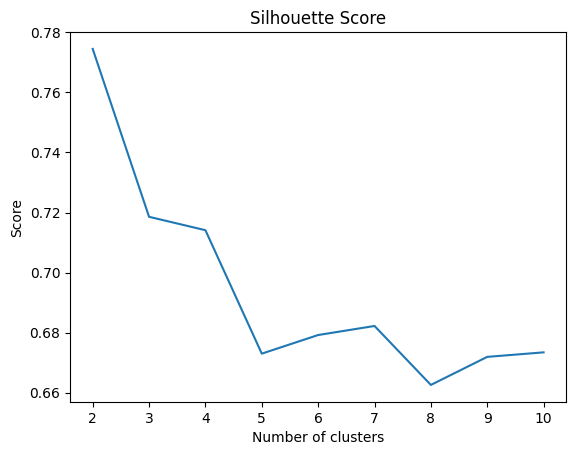

In [1104]:
# C and E
x = np.concatenate((x_c, x_e), axis=0)
y_c = np.zeros((100, 1))
y_e = np.ones((100, 1))
y = np.concatenate((y_c, y_e), axis=0)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)
wcss(x_train)
silhouette(x_train)

the number of cluster 0 is 31
the number of cluster 1 is 129


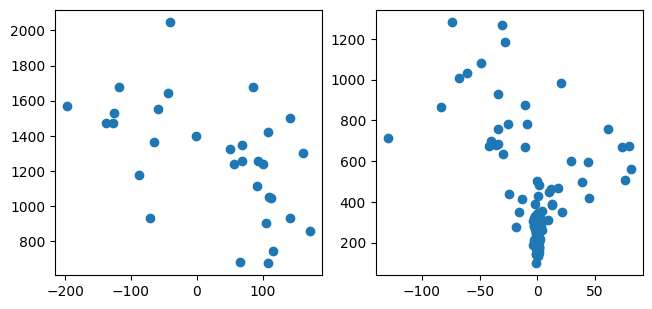

C:\Users\KASRA\AppData\Local\Temp\ipykernel_16864\466768331.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_clf.fit(x_train[kmeans.labels_ == i], y_train[kmeans.labels_ == i])
C:\Users\KASRA\AppData\Local\Temp\ipykernel_16864\466768331.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_clf.fit(x_train[kmeans.labels_ == i], y_train[kmeans.labels_ == i])


accuracy:  0.95
precision:  0.9479166666666667
recall:  0.9479166666666667
f1-score:  0.9479166666666667


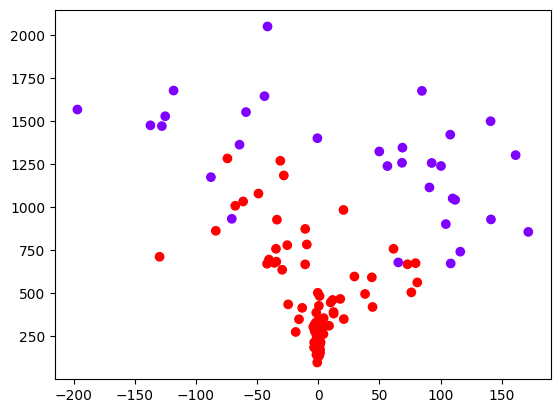

In [1105]:
k_means(x_train, x_test, y_train, y_test, 2)

In [1106]:
# 3 classes
# AB and CD and E

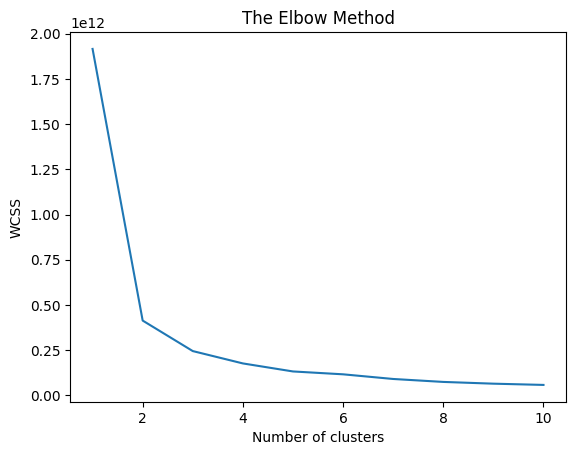

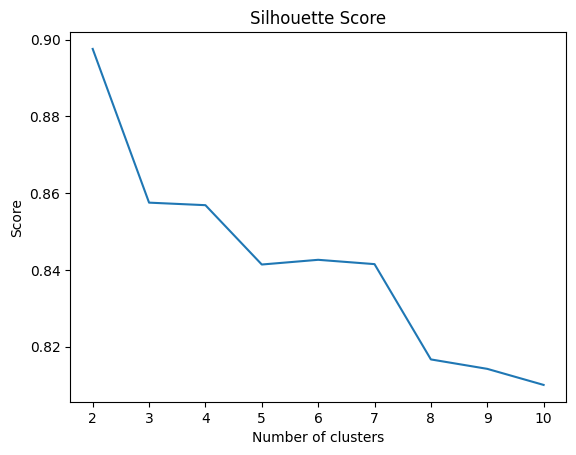

In [1107]:
# AB and CD and E
x = np.concatenate((x_a, x_b, x_c, x_d, x_e), axis=0)
y_ab = np.zeros((200, 1))
y_cd = np.ones((200, 1))
y_e = np.ones((100, 1)) * 2
y = np.concatenate((y_ab, y_cd, y_e), axis=0)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)
wcss(x_train)
silhouette(x_train)

the number of cluster 0 is 349
the number of cluster 1 is 21
the number of cluster 2 is 30


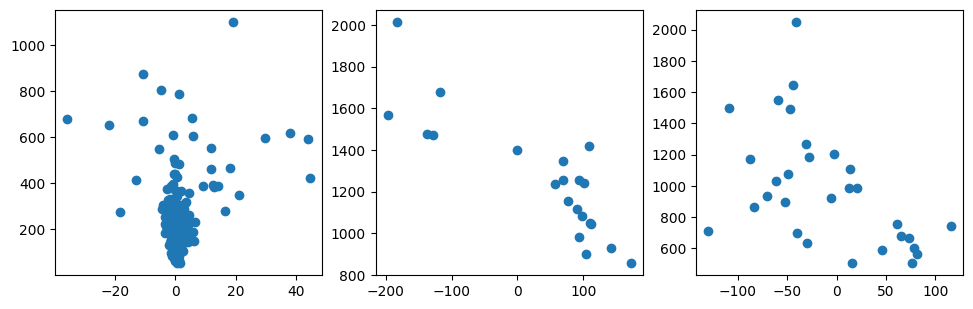

C:\Users\KASRA\AppData\Local\Temp\ipykernel_16864\466768331.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_clf.fit(x_train[kmeans.labels_ == i], y_train[kmeans.labels_ == i])
C:\Users\KASRA\AppData\Local\Temp\ipykernel_16864\466768331.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_clf.fit(x_train[kmeans.labels_ == i], y_train[kmeans.labels_ == i])
C:\Users\KASRA\AppData\Local\Temp\ipykernel_16864\466768331.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_clf.fit(x_train[kmeans.labels_ == i], y_train[kmeans.labels_ == i])


accuracy:  0.93
precision:  0.9300597731970282
recall:  0.9331254331254332
f1-score:  0.9307243660573171


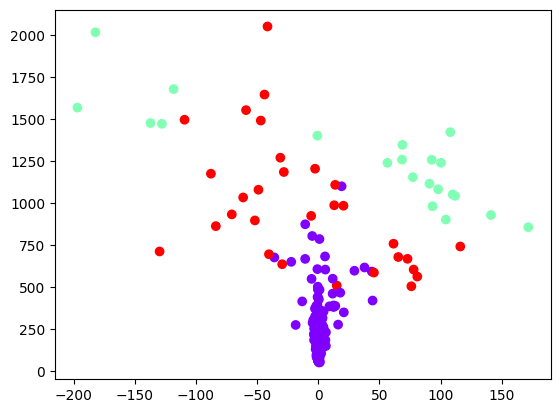

In [1108]:
k_means(x_train, x_test, y_train, y_test, 3)